In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import control as ct
from utils.MPC_funct import load_microgrid_data, CARIMA

########## Load Data
data = load_microgrid_data()
pv_power = data['pv_power']  # PV power array [W]
load_power = data['load_power']  # Load power array [W]
load_power = load_power*10  # Scaling load for simulation purposes
grid_power = data['grid_power']  # Grid power array [W]

pv_profile = np.hstack((pv_power, pv_power))  # PV generation profile [W]

load_profile = np.hstack((load_power, load_power))  # Load profile [W]

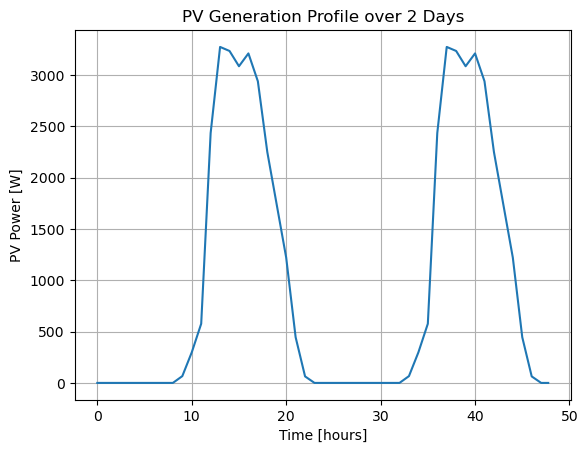

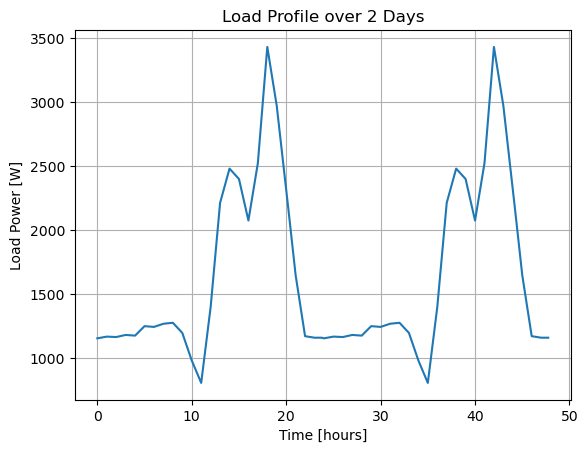

In [2]:
# Profile plotting
# Photovoltaic 
plt.figure()
plt.plot(np.arange(0, 48, 0.25), pv_profile)
plt.title('PV Generation Profile over 2 Days')
plt.xlabel('Time [hours]')
plt.ylabel('PV Power [W]')
plt.grid()
plt.show()

# Load 
plt.figure()
plt.plot(np.arange(0, 48, 0.25), load_profile)
plt.title('Load Profile over 2 Days')
plt.xlabel('Time [hours]')
plt.ylabel('Load Power [W]')
plt.grid()
plt.show()

In [3]:
########## Parameters

# Battery parameters
C_bat = [2 * 1000]  # Battery capacity [Wh]
ch_bat = [1] # Charge efficiency
SoC_CI = [0]  # Initial state of charge [%]

# Sampling parameters
ts = 15 * 60 # Sampling time [s]
samples_hour = 3600/ts # Hour in samples 

# Controller parameters
Nu = int(4 * samples_hour)  # Control horizon
Np = int(24 * samples_hour)  # Prediction horizon

# Simulation parameters
t_sim = 24 * 2  # Simulation time [h]   
Nsim = int(t_sim * samples_hour)  # Number of simulation steps

In [4]:
# Tariff Rules 
# White tariff rules for residential consumer supplied voltages lower than 2.3kV in Florianopolis, SC, Brazil in 2025
# Green flag: Off peak hours
# Yellow flag: Mid-peak hours
# Red flag: Peak hours
g_t =  0.59715 # Green flag tariff [R$/kWh]
y_t =  0.79279 # Yellow flag tariff [R$/kWh]
r_t =  1.17082 # Red flag tariff [R$/kWh]

# Tariff in a full day [R$/kWh]
tariff_daily = np.hstack((
                g_t*np.ones(int(17.5 * samples_hour)),
                y_t*np.ones(int(1 * samples_hour)),
                r_t*np.ones(int(3 * samples_hour)),
                y_t*np.ones(int(1 * samples_hour)),
                g_t*np.ones(int(1.5 * samples_hour))
))

tariff_sim = np.hstack((tariff_daily, tariff_daily))  # Tariff for the whole simulation (2 days) [R$/kWh]

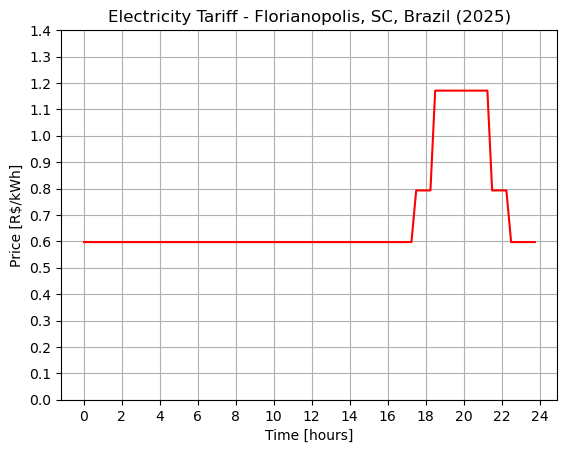

In [5]:
# Tariff plot
tx_plot = np.arange(0, 24, ts/3600)
plt.figure()
plt.plot(tx_plot, tariff_daily, color = 'red')
plt.xticks(np.arange(0, 26, 2))
plt.yticks(np.arange(0, 1.5, 0.1))
plt.title('Electricity Tariff - Florianopolis, SC, Brazil (2025)')
plt.xlabel('Time [hours]')
plt.ylabel('Price [R$/kWh]')
plt.grid()
plt.show()

In [10]:
########## Model
# Baterry Model
# SoC_a = previous SoC [Wh]
# loss = 0.995 == Self discharge per sample
#### SoC(k) = loss*SoC(k-1) + K1 * Pot(k-1)

K1 = 100*(ts/3600)*ch_bat[0]/C_bat[0]   # Charging constant 
A = np.array([1.0, -0.995])  # A polynomial coefficients
B = np.array([K1])  # B polynomial coefficients (K1)



# ts/3600 = Sampling time in hours


## GPC Matrices for Battery SoC Control

CARIMA = CARIMA(A, B, Np, Nu)
G = CARIMA["G"]
F = CARIMA["F"]

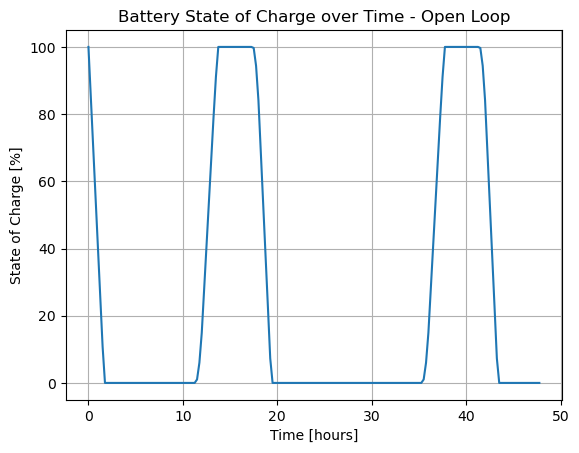

In [9]:
###### Charging Tests 

SoCk = np.zeros(Nsim)
SoCk[0] = 100 # Initial SoC

#load consumption profile
for k in range(1, Nsim):
        SoC = 0.995*SoCk[k-1] + K1*(-load_profile[k-1] + pv_profile[k-1]) 
        SoC = np.clip(SoC, 0, 100)
        SoCk[k] = SoC

plt.figure()
plt.plot(np.arange(0, t_sim, ts/3600), SoCk)
plt.title('Battery State of Charge over Time - Open Loop')
plt.xlabel('Time [hours]')
plt.ylabel('State of Charge [%]')
plt.grid()
plt.show()

